# Calculate Optimal Routes and Speeds

The code here borrows heavily from the [DeepRacer Capstone Project](https://github.com/dgnzlz/Capstone_AWS_DeepRacer) repository, which in turn builds on work from several other projects, including: 

- [DeepRacer log analysis code (DeepRacer community)](https://github.com/aws-deepracer-community/deepracer-analysis)
- [Track data (DeepRacer community)](https://github.com/aws-deepracer-community/deepracer-simapp/tree/master/bundle/deepracer_simulation_environment/share/deepracer_simulation_environment/routes)
- [K1999 Racing Lines code (calculate optimal racing line)](https://github.com/cdthompson/deepracer-k1999-race-lines)

The code here builds on this work by creating a streamlined, single-notebook process which:

1. Calculates an optimal racing line for a given DeepRacer track.
1. Calculates optimal speeds for each position along the line.
1. Generates an example reward function which follows the optimal racing line (and speeds) as closely as possible. 
1. Generates a discrete action space which include just those actions needed to race our ideal racing line. 

Note that you aren't required to follow along with the reward function example here. You can certainly write your own reward function which uses the racing line data in some other way, or use the reward function with a continuous action space, ignoring the discrete action space calculated here. 

# Calculate optimal racing line

## Load Track Data

In [1]:
# Take care of some installs (many systems will include these packages already)
!pip install --upgrade pip
!pip install scipy seaborn

# Import tools and libraries needed to compute the action space and ideal racing line
import glob
import copy
import math
import numpy as np
import pandas as pd
from scipy import stats
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

import matplotlib.pyplot as plt
import seaborn as sns
import os.path
from datetime import datetime

%matplotlib inline

# Code below helps us ignore deprecation warnings (makes the
# output from tne notebook cleaner...this is optional, comment
# this out if you want to see the warnings)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# List tracks available to work with
# Note that names may differ slightly from the ones used in the console
# For instance, re:Invent 2018 is known as "reinvent_base" here
available_track_files = glob.glob("./tracks/*.npy")
available_track_names = list(map(lambda x: os.path.basename(x).split('.npy')[0], available_track_files))

# Print a list for reference
for track in available_track_names:
    print(track)


reInvent2019_track
2022_march_open
Aragon
2022_june_pro_cw
caecer_loop
jyllandsringen_open
2022_august_open
reinvent_base_jeremiah
hamption_pro
2022_september_open_ccw
Monaco_building
2022_april_open
2022_july_pro_ccw
2022_september_pro
reInvent2019_wide_ccw
arctic_pro_cw
Canada_Training
reInvent2019_wide
dubai_open_ccw
2022_july_pro
thunder_hill_pro
2022_april_open_cw
Tokyo_Training_track
2022_august_open_cw
2022_summit_speedway_ccw
Oval_track
thunder_hill_pro_cw
2022_june_open_ccw
2022_april_pro_cw
2022_summit_speedway
2022_august_pro
2022_october_open_cw
reInvent2019_wide_mirrored
2022_reinvent_champ
reInvent2019_track_cw
AmericasGeneratedInclStart
jyllandsringen_pro
reinvent_carpet
New_York_Track
Bowtie_track
Belille
Austin
H_track
2022_october_pro_ccw
2022_april_open_ccw
2022_april_pro
2022_august_pro_ccw
Singapore
reinvent_base
2022_april_pro_ccw
2022_october_pro_cw
red_star_pro_cw
2022_august_open_ccw
2022_september_open
Mexico_track
Spain_track
Vegas_track
2022_may_open_ccw
Vir

In [3]:
# Let's choose the re:Invent 2018 track, for starters
TRACK = 'reInvent2019_track_ccw'

waypoints = np.load(f"./tracks/{TRACK}.npy")

Is loop/ring?  True


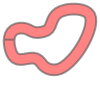

In [4]:
# Convert track data to Shapely objects so we can calcualte
# the optimal racing line more easily

# Use Shapely to generate lines for the inner 
# and outer track borders, and centerline
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

l_center_line = LineString(center_line)
l_inner_border = LineString(inner_border)
l_outer_border = LineString(outer_border)

# Create a shapely Polygon representing the track
road_poly = Polygon(np.vstack((l_outer_border.coords, np.flipud(l_inner_border.coords))))

print("Is loop/ring? ", l_center_line.is_ring)

# Show track shape (sanity check)
road_poly

Is loop/ring?  True


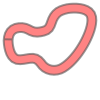

In [5]:
# Code below (borrowed directly from DeepRacer Capstone) reduces the apparent
# width of the track. The goal here is to avoid having the ideal raceline fall
# too close to the track borders, which could cause the car to go off track
# too easily

# Set PERC_WIDTH based on the required track width reduction
# Example: 0.8 means a 20% reduction (track is 80% of original width after reduction)
PERC_WIDTH = 0.8

def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5
    
def x_perc_width(waypoint, perc_width):
    
    center_x, center_y, inner_x, inner_y, outer_x, outer_y = waypoint
    
    width = dist_2_points(inner_x, outer_x, inner_y, outer_y)
    
    delta_x = outer_x-inner_x
    delta_y = outer_y-inner_y
    
    inner_x_new = inner_x + delta_x/2 * (1-perc_width)
    outer_x_new = outer_x - delta_x/2 * (1-perc_width)
    inner_y_new = inner_y + delta_y/2 * (1-perc_width)
    outer_y_new = outer_y - delta_y/2 * (1-perc_width)
    
    return [center_x, center_y, inner_x_new, inner_y_new, outer_x_new, outer_y_new]


waypoints_new = [x_perc_width(waypoint, perc_width=PERC_WIDTH) for waypoint in waypoints]
waypoints_new = np.asarray(waypoints_new)

# Convert to Shapely objects
inner_border_new = waypoints_new[:,2:4]
outer_border_new = waypoints_new[:,4:6]

l_inner_border_new = LineString(inner_border_new)
l_outer_border_new = LineString(outer_border_new)

road_poly_new = Polygon(np.vstack((l_outer_border_new.coords, np.flipud(l_inner_border_new.coords))))

print("Is loop/ring? ", l_center_line.is_ring)
road_poly_new

## Plot (Old and New) Waypoints and Calculate New Racing Line

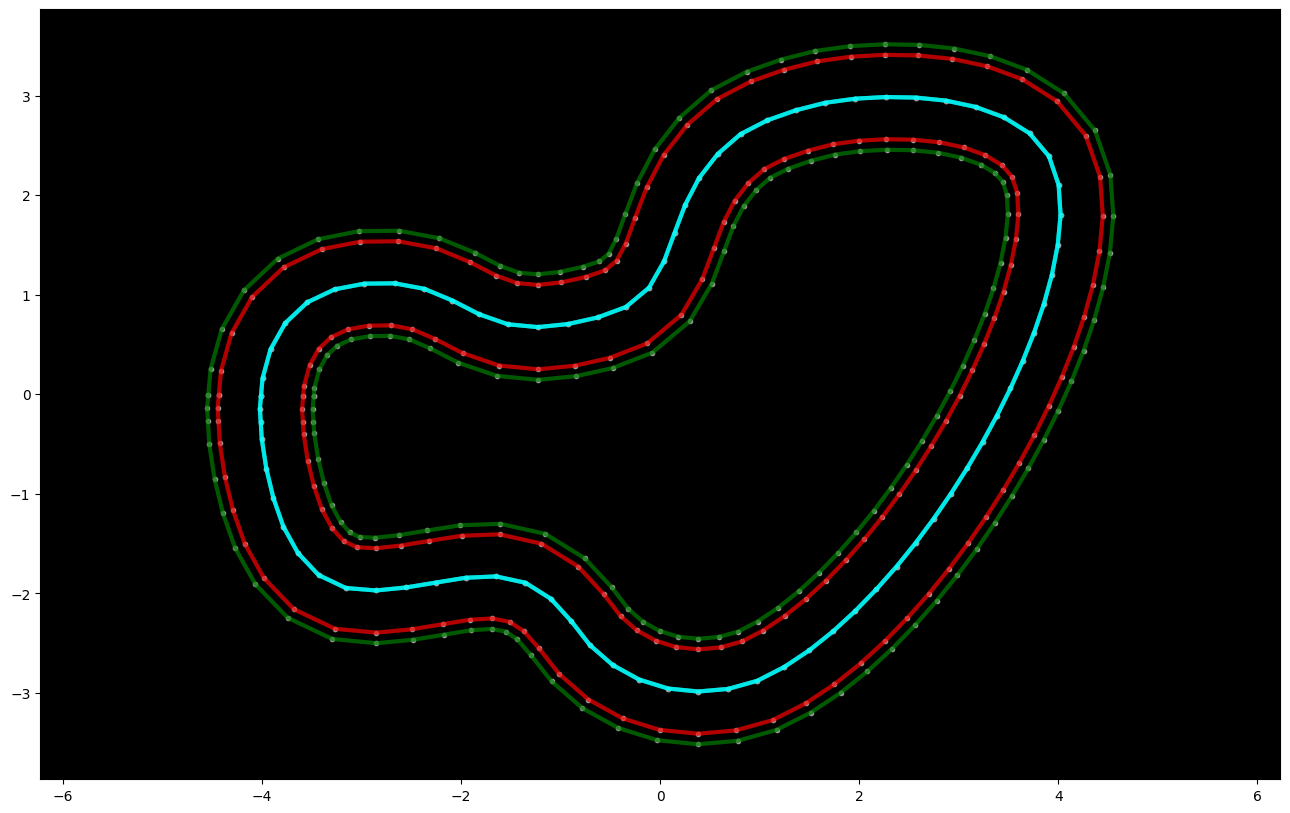

In [6]:
def plot_coords(ax, ob):                                                        
    x, y = ob.xy                                                                
    ax.plot(x, y, '.', color='#999999', zorder=1)                               
                                                                                
def plot_bounds(ax, ob):                                                        
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))                          
    ax.plot(x, y, '.', color='#000000', zorder=1)                               
                                                                                
def plot_line(ax, ob, color):                                                          
    x, y = ob.xy                                                                
    ax.plot(x, y, color=color, alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
                                                                                
def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints, color):
    line = LineString(waypoints)                                                
    plot_coords(ax, line)                                                       
    plot_line(ax, line, 'cyan') # I hard-code centerline color so that it is distinct from the borders                                                         
                                                                                
    line = LineString(inner_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line, color)                                                         
                                                                                
    line = LineString(outer_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line, color)     

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, center_line, inner_border, outer_border, 'green')

# Also print new border
print_border(ax, center_line, inner_border_new, outer_border_new, 'red')

In [7]:
# Here we directly borrow some code to calculate curvature of the ideal racing line

# From https://github.com/e-koch/ewky_scripts/blob/master/curvature.py

# The MIT License (MIT)
#
# Copyright (c) 2014 Eric Koch
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

def menger_curvature(pt1, pt2, pt3, atol=1e-3):

    vec21 = np.array([pt1[0]-pt2[0], pt1[1]-pt2[1]])
    vec23 = np.array([pt3[0]-pt2[0], pt3[1]-pt2[1]])

    norm21 = np.linalg.norm(vec21)
    norm23 = np.linalg.norm(vec23)

    theta = np.arccos(np.dot(vec21, vec23)/(norm21*norm23))
    if np.isclose(theta-np.pi, 0.0, atol=atol):
        theta = 0.0

    dist13 = np.linalg.norm(vec21-vec23)

    return 2*np.sin(theta) / dist13

In [8]:
# Code below borrowed directly from Capstone DeepRacer
def improve_race_line(old_line, inner_border, outer_border):
    '''Use gradient descent, inspired by K1999, to find the racing line'''
    # start with the center line
    new_line = copy.deepcopy(old_line)
    ls_inner_border = Polygon(inner_border)
    ls_outer_border = Polygon(outer_border)
    for i in range(0,len(new_line)):
        xi = new_line[i]
        npoints = len(new_line)
        prevprev = (i - 2 + npoints) % npoints
        prev = (i - 1 + npoints) % npoints
        nexxt = (i + 1 + npoints) % npoints
        nexxtnexxt = (i + 2 + npoints) % npoints
        #print("%d: %d %d %d %d %d" % (npoints, prevprev, prev, i, nexxt, nexxtnexxt))
        ci = menger_curvature(new_line[prev], xi, new_line[nexxt])
        c1 = menger_curvature(new_line[prevprev], new_line[prev], xi)
        c2 = menger_curvature(xi, new_line[nexxt], new_line[nexxtnexxt])
        target_ci = (c1 + c2) / 2
        #print("i %d ci %f target_ci %f c1 %f c2 %f" % (i, ci, target_ci, c1, c2))

        # Calculate prospective new track position, start at half-way (curvature zero)
        xi_bound1 = copy.deepcopy(xi)
        xi_bound2 = ((new_line[nexxt][0] + new_line[prev][0]) / 2.0, (new_line[nexxt][1] + new_line[prev][1]) / 2.0)
        p_xi = copy.deepcopy(xi)
        for j in range(0,XI_ITERATIONS):
            p_ci = menger_curvature(new_line[prev], p_xi, new_line[nexxt])
            #print("i: {} iter {} p_ci {} p_xi {} b1 {} b2 {}".format(i,j,p_ci,p_xi,xi_bound1, xi_bound2))
            if np.isclose(p_ci, target_ci):
                break
            if p_ci < target_ci:
                # too flat, shrinking track too much
                xi_bound2 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound1[0] + p_xi[0]) / 2.0, (xi_bound1[1] + p_xi[1]) / 2.0)
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound1 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
            else:
                # too curved, flatten it out
                xi_bound1 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound2[0] + p_xi[0]) / 2.0, (xi_bound2[1] + p_xi[1]) / 2.0)

                # If iteration pushes the point beyond the border of the track,
                # just abandon the refinement at this point.  As adjacent
                # points are adjusted within the track the point should gradually
                # make its way to a new position.  A better way would be to use
                # a projection of the point on the border as the new bound.  Later.
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound2 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
        new_xi = p_xi
        # New point which has mid-curvature of prev and next points but may be outside of track
        #print((new_line[i], new_xi))
        new_line[i] = new_xi
    return new_line

In [9]:
# Note that the K1999 algorithm used to calculate the racing line
# is an iterative algorithm. The two parameters below are set to 
# sensible defaults. Increasing them will result in a "better" 
# (more mathematically ideal) fit to the racing line
XI_ITERATIONS=8
LINE_ITERATIONS=1000

# Perform the calculations!
# WARNING: Depending how your constants are set above, this may take some time

print(f"Length of centerline (number of waypoints): {len(center_line)}")
# start along centerline of track
race_line = copy.deepcopy(center_line[:-1])  # Use this for centerline being outer bound
print("Starting...")
for i in range(LINE_ITERATIONS):
    race_line = improve_race_line(race_line, inner_border_new, outer_border_new)  # Remove "_new" for entire track width
    if i % 10 == 0:
        print(f"Progress: {round(i/LINE_ITERATIONS*100)}%", end="\r", flush=True)
print("\nDone!")

Length of centerline (number of waypoints): 79
Starting...
Progress: 99%
Done!


These should be the same:  ((79, 2), (79, 2))
Original centerline length: 23.09
New race line length: 20.22


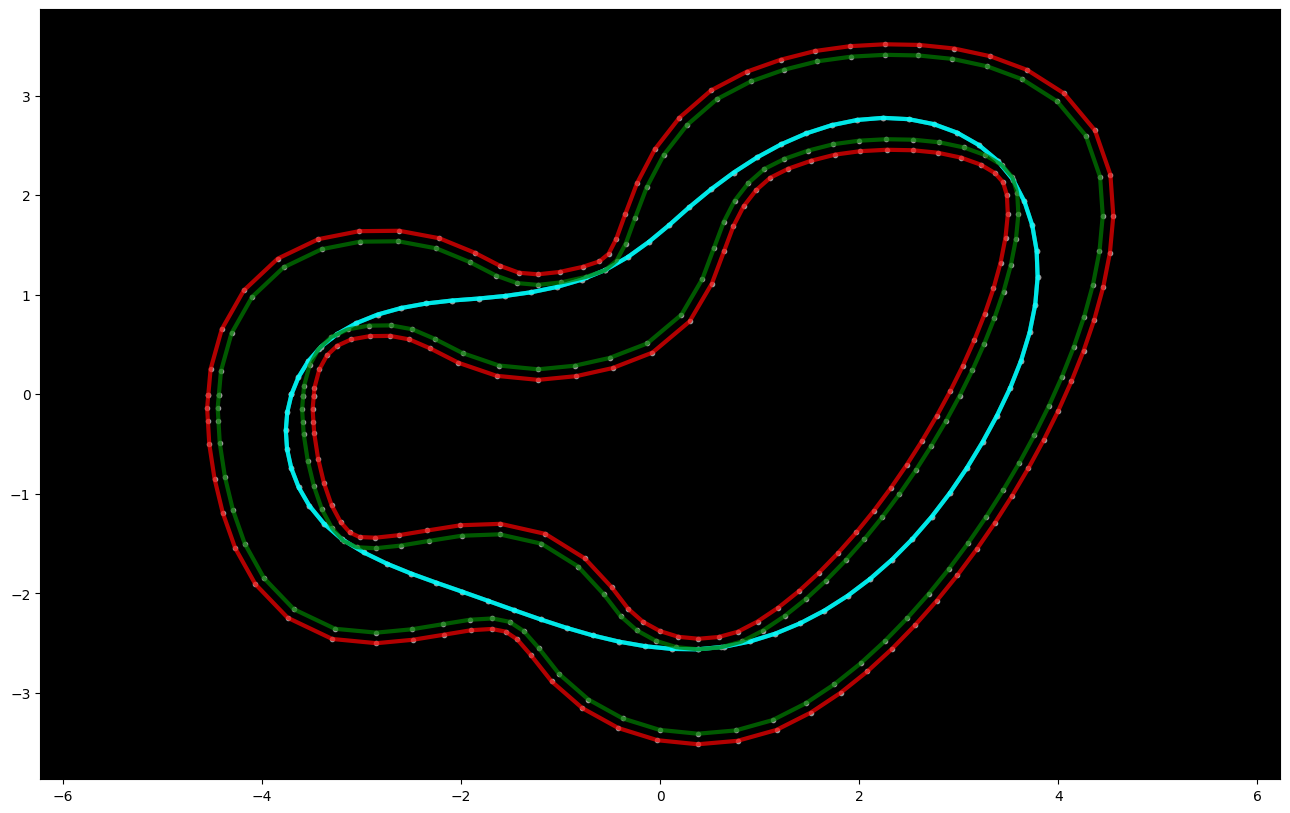

In [10]:
# Ensure the new racing line represents a closed loop (first and last points must be the same)
loop_race_line = np.append(race_line, [race_line[0]], axis=0)

# Sanity check (is the line a closed loop?)
print("These should be the same: ", (center_line.shape, loop_race_line.shape))
print("Original centerline length: %0.2f" % l_center_line.length)
print("New race line length: %0.2f" % LineString(loop_race_line).length)

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, loop_race_line, inner_border, outer_border, 'red')

# Also print new border
print_border(ax, loop_race_line, inner_border_new, outer_border_new, 'green')

### Save the raceline to a file

In [11]:
# Save results to file
prefix = f"./racing_optimals/{TRACK}"
py_fname = prefix + '.py'
npy_fname = prefix + '.npy'
with open(py_fname, "w") as file:
    print("Writing python code to %s" % py_fname)
    file.write(np.array_repr(loop_race_line))

print("Writing numpy binary to %s" % npy_fname)
np.save(npy_fname, loop_race_line)

Writing python code to ./racing_optimals/reInvent2019_track_ccw.py
Writing numpy binary to ./racing_optimals/reInvent2019_track_ccw.npy


### Sanity check: reload the racing line from a file

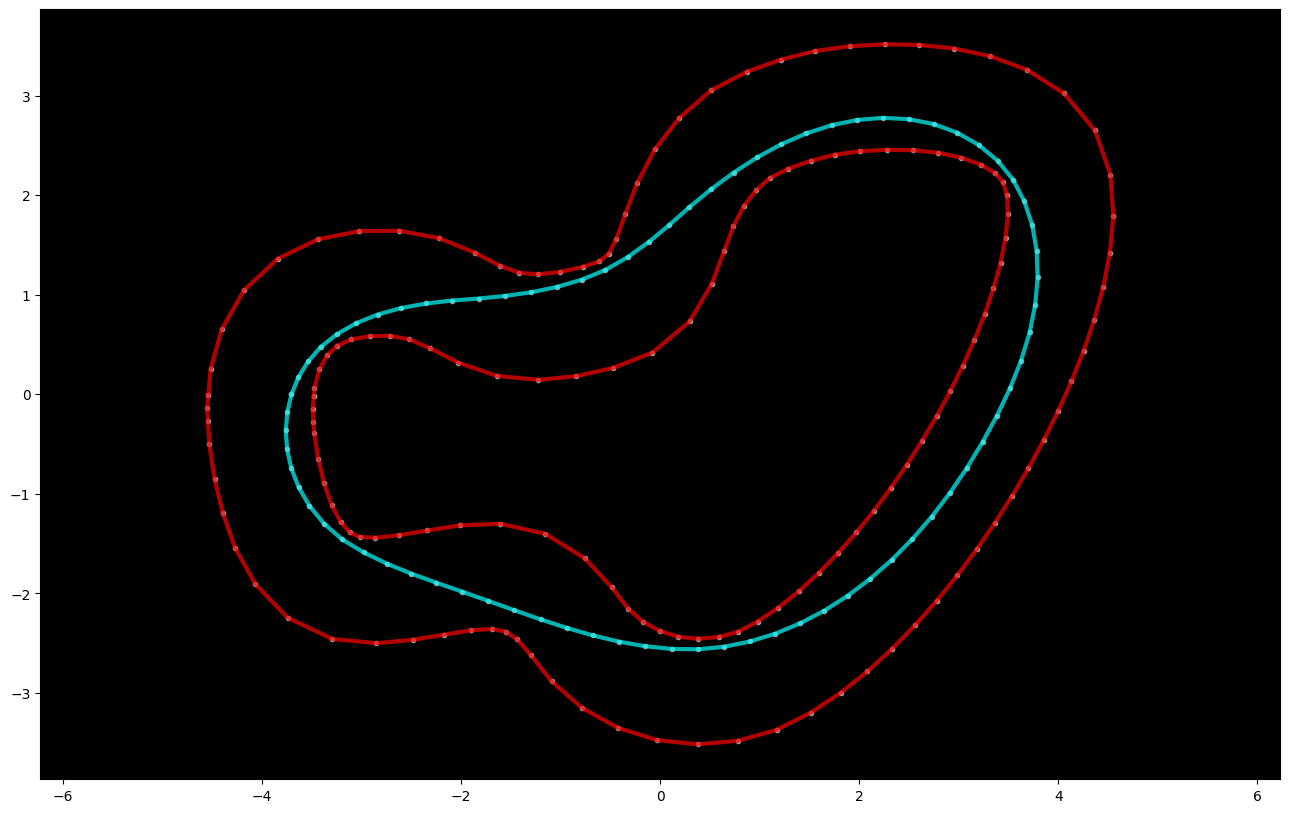

In [12]:
# Note the np.array function must be available directly as "array"
# for the code below to run, hence the additional import statement
from numpy import array

fname = f"./racing_optimals/{TRACK}.py"
with open(fname, "r") as file:
    deserialized = eval(file.read())
deserialized
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, deserialized, inner_border, outer_border, 'red')

## Optional: Cleanup

Uncomment and run the code below to delete old optimal racing line data

In [13]:
#!rm -rf ./racing_optimals/*

# Calculate optimal speeds

Below, we try to calculate **optimal speeds** at each point along our racing line

In [14]:
# Load the line
racing_track = np.load(f"./racing_optimals/{TRACK}.npy")

# Convert Numpy array to list and remove last point (it's a duplicate to ensure a closed loop)
racing_track = racing_track.tolist()[:-1]

### Helper functions

Code below borrowed directly from the Capstone DeepRacer project.

In [15]:
# Uses previous and next coords to calculate the radius of the curve
# so you need to pass a list with form [[x1,y1],[x2,y2],[x3,y3]]
# Input 3 coords [[x1,y1],[x2,y2],[x3,y3]]
def circle_radius(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    a = x1*(y2-y3) - y1*(x2-x3) + x2*y3 - x3*y2
    b = (x1**2+y1**2)*(y3-y2) + (x2**2+y2**2)*(y1-y3) + (x3**2+y3**2)*(y2-y1)
    c = (x1**2+y1**2)*(x2-x3) + (x2**2+y2**2)*(x3-x1) + (x3**2+y3**2)*(x1-x2)
    d = (x1**2+y1**2)*(x3*y2-x2*y3) + (x2**2+y2**2) * \
        (x1*y3-x3*y1) + (x3**2+y3**2)*(x2*y1-x1*y2)

    # In case a is zero (so radius is infinity)
    try:
        r = abs((b**2+c**2-4*a*d) / abs(4*a**2)) ** 0.5
    except:
        r = 999

    return r


# Returns indexes of next index and index+lookfront
# We need this to calculate the radius for next track section.
def circle_indexes(mylist, index_car, add_index_1=0, add_index_2=0):

    list_len = len(mylist)

    # if index >= list_len:
    #     raise ValueError("Index out of range in circle_indexes()")

    # Use modulo to consider that track is cyclical
    index_1 = (index_car + add_index_1) % list_len
    index_2 = (index_car + add_index_2) % list_len

    return [index_car, index_1, index_2]


def optimal_velocity(track, min_speed, max_speed, look_ahead_points):

    # Calculate the radius for every point of the track
    radius = []
    for i in range(len(track)):
        indexes = circle_indexes(track, i, add_index_1=-1, add_index_2=1)
        coords = [track[indexes[0]],
                  track[indexes[1]], track[indexes[2]]]
        radius.append(circle_radius(coords))

    # Get the max_velocity for the smallest radius
    # That value should multiplied by a constant multiple
    v_min_r = min(radius)**0.5
    constant_multiple = min_speed / v_min_r
    print(f"Constant multiple for optimal speed: {constant_multiple}")

    if look_ahead_points == 0:
        # Get the maximal velocity from radius
        max_velocity = [(constant_multiple * i**0.5) for i in radius]
        # Get velocity from max_velocity (cap at MAX_SPEED)
        velocity = [min(v, max_speed) for v in max_velocity]
        return velocity

    else:
        # Looks at the next n radii of points and takes the minimum
        # goal: reduce lookahead until car crashes bc no time to break
        LOOK_AHEAD_POINTS = look_ahead_points
        radius_lookahead = []
        for i in range(len(radius)):
            next_n_radius = []
            for j in range(LOOK_AHEAD_POINTS+1):
                index = circle_indexes(
                    mylist=radius, index_car=i, add_index_1=j)[1]
                next_n_radius.append(radius[index])
            radius_lookahead.append(min(next_n_radius))
        max_velocity_lookahead = [(constant_multiple * i**0.5)
                                  for i in radius_lookahead]
        velocity_lookahead = [min(v, max_speed)
                              for v in max_velocity_lookahead]
        return velocity_lookahead


# For each point in racing track, check if left curve (returns boolean)
def is_left_curve(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    return ((x2-x1)*(y3-y1) - (y2-y1)*(x3-x1)) > 0


# Calculate the distance between 2 points
def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5

In [16]:
# Below we set some parameters which will act as 
# "guideliens" for calculating the optimal speed
#
# On especially "curvy" tracks, it may be necessary
# to avoid looking so far ahead, or we may be able 
# to increase the minimum speed somewhat
#
# Play with these to find optimal values for you
LOOK_AHEAD_POINTS = 3
MIN_SPEED = 1.5
MAX_SPEED = 4

# Calculate optimal speed
velocity = optimal_velocity(track=racing_track, 
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=LOOK_AHEAD_POINTS)

Constant multiple for optimal speed: 1.438339643104756


### Visualize results

Constant multiple for optimal speed: 1.438339643104756


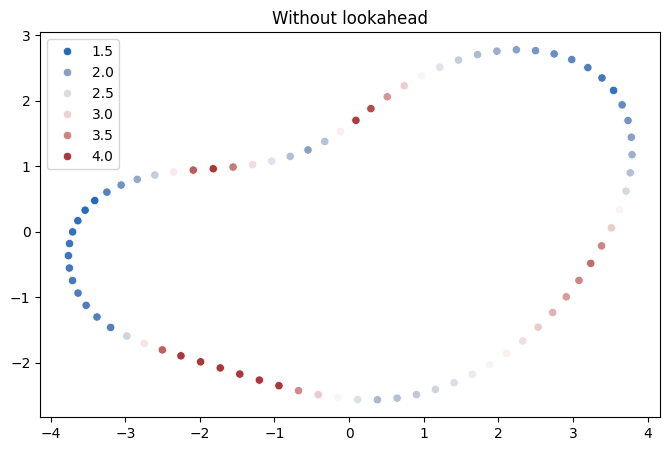

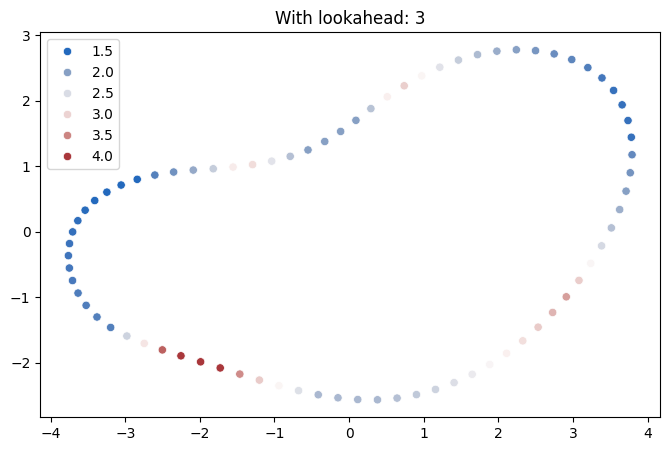

In [17]:
# Let's print out our line with "hot" (red) colors indicating
# higher speeds and "cool" (blue) colors indicating lower speeds
x = [i[0] for i in racing_track]
y = [i[1] for i in racing_track]

# Without lookahead (for comparison - we usually want lookahead)
velocity_no_lookahead = optimal_velocity(track=racing_track,
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=0)

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity_no_lookahead,
                     palette="vlag").set_title("Without lookahead")

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity, palette="vlag").set_title(
    f"With lookahead: {LOOK_AHEAD_POINTS}")

### Save waypoints (including velocity) to a file

In [18]:
# Save full results (X, Y, speed) to CSV file
fname = f"./racing_optimals/{TRACK}_waypoint_speeds.csv"
with open(fname, "w") as file:
    file.write("X, Y, Speed\n")
    for i in range(0, len(velocity)):
        file.write(f"{loop_race_line[i][0]}, {loop_race_line[i][1]}, {velocity[i]}\n")

print("Done!")

Done!


## Estimate Results of a "Perfect Run"

This code is also borrowed directly from the DeepRacer Capstone project, and attempts to work out what the lap time(s) would be if the racing line was followed perfectly, exactly at the speeds determined above.

Note we are using the speeds calculated **with lookahead**, as we usually don't want the car to come up on a turn at full speed! 

In [19]:
distance_to_prev = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=0)[0:2]
    coords = [racing_track[indexes[0]],racing_track[indexes[1]]]
    dist_to_prev = dist_2_points(x1=coords[0][0], x2=coords[1][0], y1=coords[0][1], y2=coords[1][1])
    distance_to_prev.append(dist_to_prev)
    
time_to_prev = [(distance_to_prev[i]/velocity[i]) for i in range(len(racing_track))]

total_time = sum(time_to_prev)
print(f"Total time for track, if racing line and speeds are followed perfectly: {total_time} s")

Total time for track, if racing line and speeds are followed perfectly: 9.298983361548872 s


# Calculate Optimal Action Space

Now that we know what our optimal speeds are, let's calculate an associated optimal (discrete) action space. 

This code is (mostly) copied from the DeepRacer Capstone code, but I take the extra precaution of rouding speeds and steering angles to the closest 10th, not just for readability but to make them easier to type in for users who are doing things in the DeepRacer Console instead of using the local [DeepRacer for Cloud](https://aws-deepracer-community.github.io/deepracer-for-cloud/) training environment. 

In [20]:
# Helper code from DeepRacer capstone, to calculate (turning) radius at each point on the track
radius = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=1) # CHANGE BACK? 1;2
    coords = [racing_track[indexes[0]],
              racing_track[indexes[1]], racing_track[indexes[2]]]
    radius.append(circle_radius(coords))

# Calculate curve direction
left_curve = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=1)
    coords = [racing_track[indexes[1]],
              racing_track[indexes[0]], racing_track[indexes[2]]]
    left_curve.append(is_left_curve(coords))

# Calculate radius with + and - for direction (+ is left, - is right)
radius_direction = []
for i in range(len(racing_track)):
    radius_with_direction = radius[i]
    if left_curve[i] == False:
        radius_with_direction *= -1
    radius_direction.append(radius_with_direction)

# Calculate steering with + and -
dist_wheels_front_back = 0.165 # meters
steering = []
for i in range(len(racing_track)):
    steer = math.degrees(math.asin(dist_wheels_front_back/radius_direction[i]))
    steering.append(steer)
    
# Merge relevant lists into dataframe
all_actions = pd.DataFrame({"velocity":velocity,
                            "steering":steering})

In [21]:
print(f"Minimum radius: {min(radius)}")

Minimum radius: 1.087576004544423


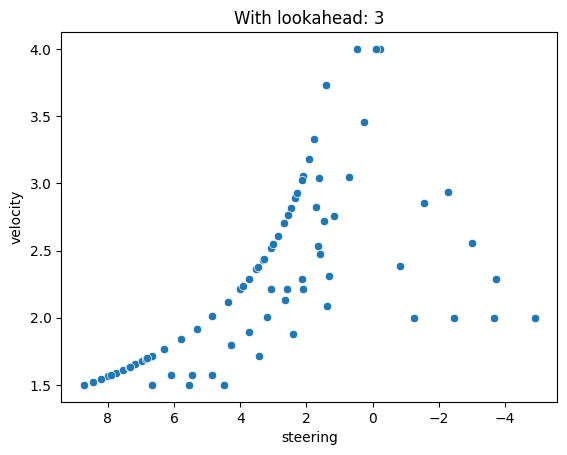

In [22]:
# Visualize associated action space, with lookahead
ax = sns.scatterplot(data=all_actions, x="steering", y="velocity")
ax.invert_xaxis()
ax.set_title(f"With lookahead: {LOOK_AHEAD_POINTS}")
r = ax.plot()

### Visualize Actions Taken

Some notes on reading the first graph (speed vs steering):
    
1. The **dotted green line** represents a steering angle of zero (straight)
1. The **solid green line** represents steering angles. **Postivie** numbers represent steering to the **left**, **negative** numbers indicate steering to the **right**)
1. The **solid red line** represents the car's speed


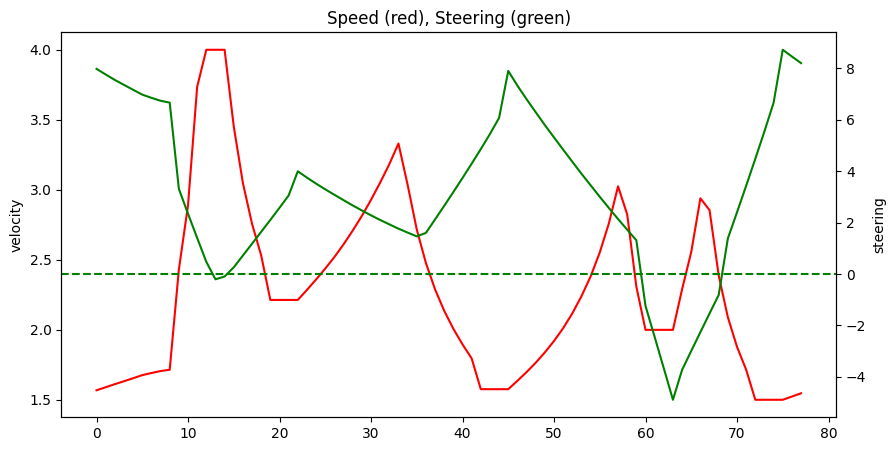

In [23]:
# Visualize our actions
# What actions will we take? 

plt.figure(figsize=(10, 5))
sns.lineplot(data=all_actions["velocity"], color="r")
ax2 = plt.twinx()
sns.lineplot(data=all_actions["steering"], color="g", ax=ax2)
plt.axhline(0, ls='--', color="g")
a = plt.title("Speed (red), Steering (green)")

## Calculate the Ideal Action Space

Again this code comes right from the DeepRacer Capstone project. 

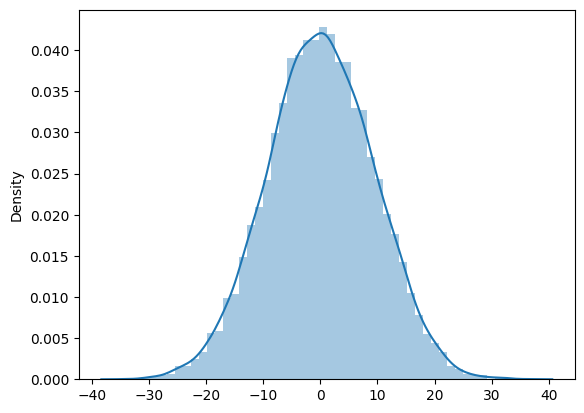

In [24]:
# Steering: Find a standard deviation which tries to avoid oversteer (steering outside 15 degrees)
steering_sd = -15 / stats.norm.ppf(0.05)
steering_sd
s = sns.distplot(np.random.normal(0,steering_sd,10000))

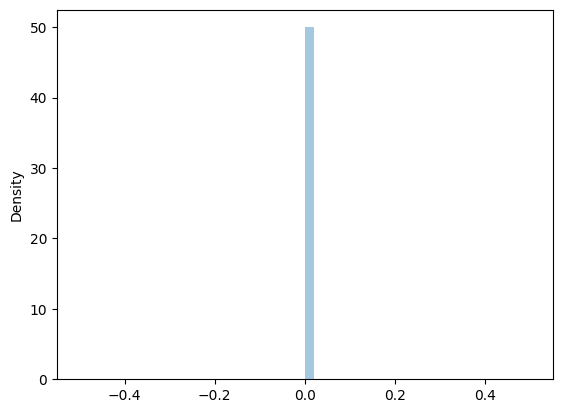

In [25]:
# Velocity: Find a standard deviation that minimizes rapid velocity change (> 0.25 m/s)
velocity_sd = -0.25 / stats.norm.ppf(0.00)
velocity_sd
v = sns.distplot(np.random.normal(0,velocity_sd,10000))

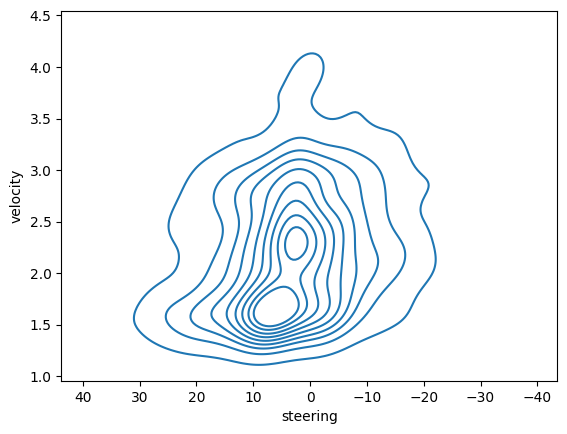

In [26]:
# Borrowed directly from DeepRacer Capstone
# Generate a new action space from the list of all actions taken
# to get around the track in minimum time (calculated earlier in the notebook)
all_actions_norm = all_actions.copy()

all_actions_norm_len = len(all_actions_norm)
resample_size = 1000

# Add gaussian noise to action space
for i in range(all_actions_norm_len):
    v_true = all_actions_norm.iloc[i]["velocity"]
    s_true = all_actions_norm.iloc[i]["steering"]
    v_norm = np.random.normal(loc=v_true, scale=velocity_sd, size=resample_size)
    s_norm = np.random.normal(loc=s_true, scale=steering_sd, size=resample_size)
    vs_norm = pd.DataFrame(np.column_stack([v_norm,s_norm]), columns=["velocity","steering"])
    all_actions_norm = pd.concat([all_actions_norm,vs_norm], axis=0, ignore_index=True)
    
# Take out actions with max speed, so that they are not affected by gaussian noise
# We do this because there are disproportionally many points with max speed, so 
# K-Means will focus too much on these
all_actions_norm = all_actions_norm[all_actions_norm["velocity"] < MAX_SPEED]
    
# Add initial actions to action space (to make clustering more focused on initial actions)
add_n_initial_actions = int(resample_size / 8)
add_initial_actions = pd.DataFrame()
for i in range(add_n_initial_actions):
    add_initial_actions = pd.concat([add_initial_actions,all_actions], axis=0, ignore_index=True)
all_actions_norm = pd.concat([all_actions_norm,add_initial_actions], axis=0, ignore_index=True)


# Display actions shape
all_actions_norm.shape

all_actions_norm_less = all_actions_norm.sample(frac=0.01).reset_index(drop=True) # sample bc less compute time

ax = sns.kdeplot(x=all_actions_norm_less["steering"], y=all_actions_norm_less["velocity"])
ax.invert_xaxis()

In [27]:
# Force threadpoolctl to fix issue with .fit()
!pip install --upgrade threadpoolctl

In [28]:
X = copy.deepcopy(all_actions_norm)

# Calculate action space with KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans

# Rescale data with minmax
minmax_scaler = MinMaxScaler()
X_minmax = pd.DataFrame(minmax_scaler.fit_transform(X), columns=["velocity","steering"])

# Sanity checks:
print(f"\nNumber of non-number entries:\n{X_minmax.isna().sum()}\n")
print(f"\nNumber of different datatypes:\n{X_minmax.dtypes}\n")

# KMeans
# remove 2 actions from KMeans so that low speed & high steering actions can be manually included
n_clusters = 21-2
model = MiniBatchKMeans(n_clusters=n_clusters)
model = model.fit(X_minmax)

# Centroids (interpretable)
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
X_minmax_fit = minmax_scaler.fit(X)
X_centroids = pd.DataFrame(X_minmax_fit.inverse_transform(model.cluster_centers_), 
                                   columns=["velocity","steering"])

# Add 2 manual actions
# Reason: When car starts new episode, it does not start on or direction of racing line, so 
# it cannot steer enough to get on racing line
manual_actions = pd.DataFrame({"velocity":[MIN_SPEED,MIN_SPEED],"steering":[30,-30]})
X_centroids = pd.concat([X_centroids,manual_actions], ignore_index=True)

action_space_e = X_centroids.copy()


Number of non-number entries:
velocity    0
steering    0
dtype: int64


Number of different datatypes:
velocity    float64
steering    float64
dtype: object



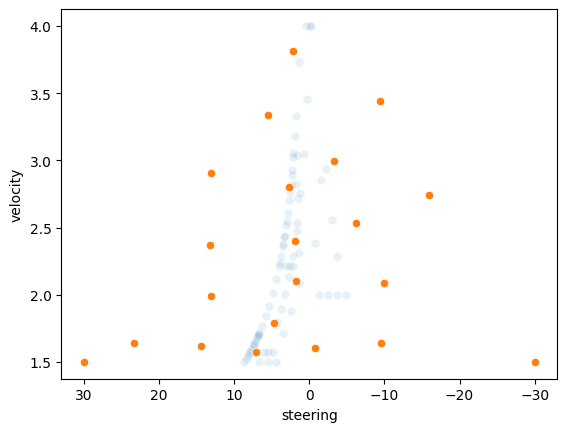

In [29]:
ax = sns.scatterplot(data=all_actions, x="steering", y="velocity", alpha=.1)
ax = sns.scatterplot(data=action_space_e, x="steering", y="velocity")
ax.invert_xaxis()

In [30]:
## Save results in JSON format
# Note that we round to 1 decimal place here
action_space_for_json = action_space_e[["steering","velocity"]].copy()
    
action_space_for_json = action_space_for_json.round(1)
action_space_for_json.columns = ["steering_angle","speed"]
action_space_for_json["index"] = action_space_for_json.index
json_text = action_space_for_json.to_json(orient="records", lines=False)

# Take a look at the generated JSON
print(action_space_for_json)

    steering_angle  speed  index
0             13.1    2.9      0
1              4.7    1.8      1
2             -6.3    2.5      2
3              1.8    2.1      3
4             14.5    1.6      4
5             -9.4    3.4      5
6             13.2    2.4      6
7             -9.9    2.1      7
8             13.1    2.0      8
9             -3.3    3.0      9
10             2.2    3.8     10
11            -9.6    1.6     11
12           -15.9    2.7     12
13             1.9    2.4     13
14            23.4    1.6     14
15            -0.8    1.6     15
16             5.5    3.3     16
17             2.7    2.8     17
18             7.1    1.6     18
19            30.0    1.5     19
20           -30.0    1.5     20


In [31]:
# Output to disk (JSON)
import json
filepath_json = f"./racing_optimals/{TRACK}_actionspace.json"

with open(filepath_json, 'w') as f:
    json.dump(json_text, f)
    
print("Done!")

Done!


In [32]:
# For easy reading, produce a copy of the action space in CSV format as well.
filepath_csv = f"./racing_optimals/{TRACK}_actionspace.csv"

with open(filepath_csv, 'w') as f:
    f.write("Index, Steering Angle, Speed\n")
    for i in range(0, len(action_space_for_json)):
        index = str(i)
        steering = action_space_for_json['steering_angle'][i]
        speed = action_space_for_json['speed'][i]
        f.write(f"{index}, {steering}, {speed}\n")
        
print("Done!") 

Done!


# Cleanup

Uncomment and run the cell below to delete your racing lines and action spaces. 

In [33]:
#!rm -rf ./racing_optimals/*